In [1]:
import pandas as pd
import numpy as np
import os
import random

from mlchartist.array_builder import build_arrays
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [2]:
min_len = 60

filenames = []

for file in os.listdir(r'../raw_data/processed'):
    if file.endswith('.csv'):
        with open('../raw_data/processed/' + file) as f:
            rows_num = sum(1 for line in f)
            if rows_num >= min_len:
                filenames.append(file)
                    

In [3]:
len(filenames)

3204

In [ ]:
all_count = len(filenames)

In [4]:
dfs = []

for ticker in filenames:
    ticker_df = pd.read_csv('../raw_data/processed/'+ticker)
    dfs.append(ticker_df)

In [5]:
df = pd.concat(dfs)

In [6]:
#df = pd.read_csv('../raw_data/processed/aapl.csv')

In [7]:
df.tail()

,ticker,date,RSI,Stochastic,Stochastic_signal,ADI,OBV,ATR,ADX,ADX_pos,ADX_neg,MACD,MACD_diff,MACD_signal,5TD_return,10TD_return,20TD_return,1D_past_return,5D_past_return,10D_past_return
595,AVRO,2020-12-17,56.319815,93.277311,85.157422,1.980553e+06,6401289,0.851025,14.698465,28.719512,17.203490,-0.298820,0.183436,-0.482256,-0.007437,-0.014875,-0.013523,0.021409,0.119606,0.104556
596,AVRO,2020-12-18,56.775164,95.378151,95.203259,2.620524e+06,7250705,0.842380,15.439775,26.941790,16.138603,-0.199146,0.226488,-0.425634,-0.010782,-0.036388,0.006065,0.003381,0.115370,0.118312
597,AVRO,2020-12-21,60.255465,96.376812,95.010758,2.878279e+06,7572104,0.854353,16.546420,28.011003,14.775835,-0.087674,0.270368,-0.358042,-0.063033,-0.016415,-0.078135,0.026280,0.128148,0.176971
598,AVRO,2020-12-22,54.445098,72.666667,88.140543,2.705945e+06,7372559,0.856185,17.811192,27.956802,13.691062,-0.037630,0.256330,-0.293960,-0.015593,0.067797,-0.010847,-0.031517,0.069616,0.150546
599,AVRO,2020-12-23,57.134504,82.333333,83.792271,2.828058e+06,7535376,0.840743,18.570029,26.436688,14.730764,0.025142,0.255281,-0.230139,-0.073138,0.002660,-0.008644,0.019661,0.038674,0.173167


In [8]:
df['date'] = pd.to_datetime(df['date'])

In [9]:
FIVE_TR = 0.0006
TEN_TR = 0.0012
TWENTY_TR = 0.0024
INPUT_COLS = ['RSI', 'Stochastic', 'Stochastic_signal', 'ADI','OBV', 'ATR', 'ADX', 'ADX_pos', 'ADX_neg', 'MACD', 'MACD_diff','MACD_signal', '1D_past_return', '5D_past_return', '10D_past_return']
#INPUT_COLS = ['RSI', 'Stochastic', 'Stochastic_signal']

In [10]:
df['5D_return_bin'] = (df['5TD_return'] >= FIVE_TR)
df['10D_return_bin'] = (df['10TD_return'] >= TEN_TR)
df['20D_return_bin'] = (df['20TD_return'] >= TWENTY_TR)

In [11]:
test_df = df[df['date'].dt.year >= 2018]
train_df = df[df['date'].dt.year < 2018]

In [ ]:
train_df

In [ ]:
test_df.shape

In [13]:
outlier_comp = set()

In [14]:
outlier_comp.update(train_df[train_df['ATR'] > 100]['ticker'].unique())

In [16]:
outlier_comp.update(train_df[(train_df['Stochastic'] > 100) | (train_df['Stochastic'] < 0)]['ticker'].unique())

In [17]:
outlier_comp.update(train_df[(train_df['Stochastic_signal'] > 110) | (train_df['Stochastic_signal'] < -10)]['ticker'].unique())

In [18]:
outlier_comp.update(train_df[(train_df['1D_past_return'] > .5) | (train_df['1D_past_return'] < -.5)]['ticker'].unique())

In [19]:
len(outlier_comp)

535

In [20]:
train_df_clean = train_df[~train_df['ticker'].isin(outlier_comp)]

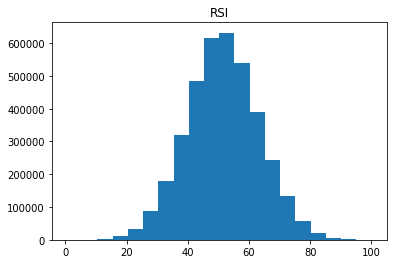

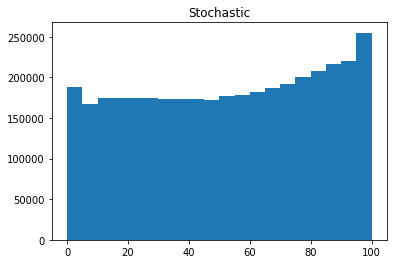

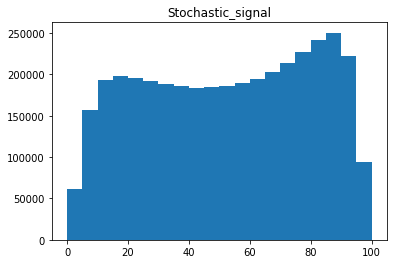

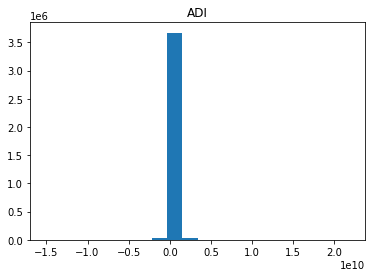

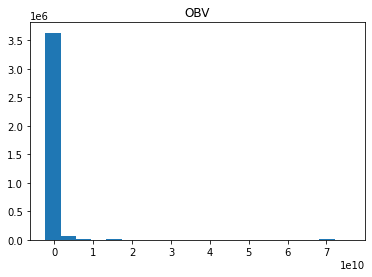

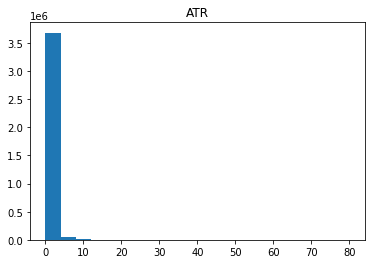

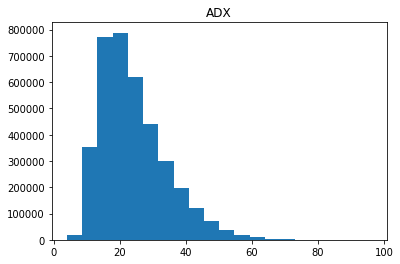

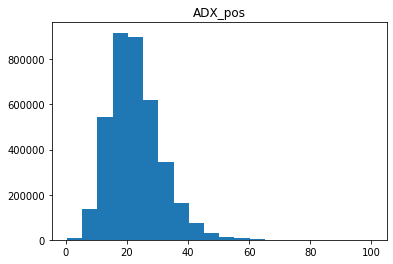

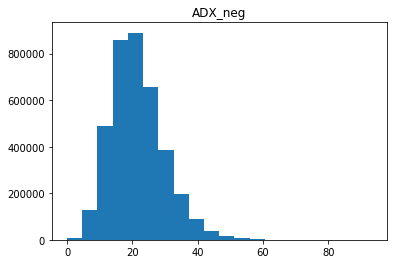

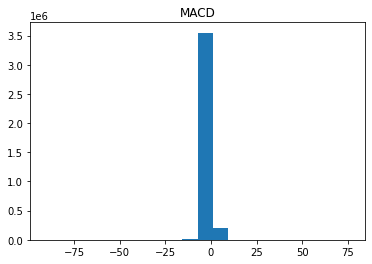

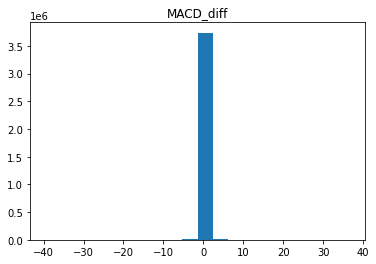

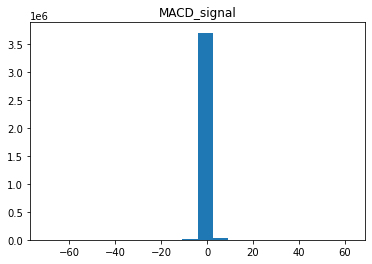

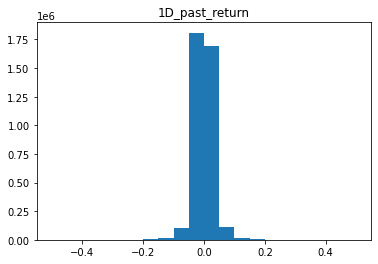

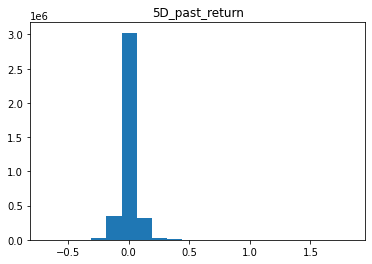

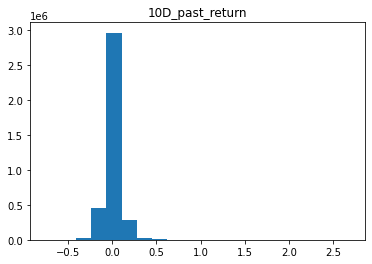

In [21]:
import matplotlib.pyplot as plt
for col in INPUT_COLS:
    plt.hist(train_df_clean[col], bins=20)
    plt.title(col)
    plt.show()

In [ ]:
len(train_df_clean)

In [ ]:
plt.hist(train_df_clean['10TD_return'], bins=50)

In [ ]:
scaler = RobustScaler()

scaler.fit(train_df[INPUT_COLS])

train_clean = train_df_clean.copy()
train_clean[INPUT_COLS] = scaler.transform(train_df_clean[INPUT_COLS])
test_df.loc[:, INPUT_COLS] = scaler.transform(test_df[INPUT_COLS])

In [ ]:
train_clean

In [ ]:
tickers = df['ticker'].unique()

In [ ]:
len(tickers)

In [ ]:
train_x_dfs = []
train_y_dfs = []
test_x_dfs = []
test_y_dfs = []

In [ ]:
ticker_counter = 0
empty_tickers = 0
for ticker in tickers:
    if ticker in list(train_clean['ticker']):
        ticker_train_df = train_clean[train_clean['ticker'] == ticker]
        ticker_train_x, ticker_train_y = build_arrays(ticker_train_df,input_cols=INPUT_COLS, target_col='20D_return_bin', time_window=30, stride=1)
        if len(ticker_train_x) != 0:
            train_x_dfs.append(ticker_train_x)
            train_y_dfs.append(ticker_train_y)
        else:
            empty_tickers += 1
        ticker_counter += 1
        if ticker_counter % 50 == 0:
            print(f'{ticker_counter} files processed, {round(ticker_counter/len(tickers)*100)}%, empty tickers: {empty_tickers}')

In [ ]:
import joblib

joblib.dump(train_x_dfs, '../raw_data/feature_arrays/train_x_dfs')

In [ ]:
joblib.dump(train_y_dfs, '../raw_data/feature_arrays/train_y_dfs')

In [ ]:
list(test_df['ticker'].unique())

In [ ]:
ticker_counter = 0
ticker_processed = 0
empty_tickers = 0
for ticker in tickers:
    ticker_counter += 1
    if ticker in list(test_df['ticker'].unique()):
        ticker_test_df = test_df[test_df['ticker'] == ticker]
        ticker_test_x, ticker_test_y = build_arrays(ticker_test_df, input_cols=INPUT_COLS, target_col='20D_return_bin', time_window=30, stride=1)
        if len(ticker_test_x) != 0:
            test_x_dfs.append(ticker_test_x)
            test_y_dfs.append(ticker_test_y)
            ticker_processed += 1
        else:
            empty_tickers += 1
        if ticker_counter % 50 == 0:
            print(f'{ticker_counter} tickers processed, {round(ticker_counter/len(tickers)*100)}%, empty tickers: {empty_tickers}, tikers done {ticker_processed}')

In [ ]:
import joblib
joblib.dump(test_x_dfs, '../raw_data/feature_arrays/test_x_dfs')
joblib.dump(test_y_dfs, '../raw_data/feature_arrays/test_y_dfs')

In [ ]:
len(test_x_dfs)

In [ ]:
test_x_dfs = joblib.load('../raw_data/feature_arrays/test_x')

In [ ]:
test_y_dfs = joblib.load('../raw_data/feature_arrays/test_y')

In [ ]:
len(test_x_dfs)

In [ ]:
import numpy as np

In [ ]:
empty_idxs = []
for i in range(len(test_x_dfs)):
    if len(test_x_dfs[i]) == 0:
        empty_idxs.append(i)

In [ ]:
empty_idxs

In [ ]:
len(test_x_dfs)

In [ ]:
train_x_dfs = np.delete(np.array(train_x_dfs), empty_idxs)

In [ ]:
len(train_y_dfs)

In [ ]:
train_x_dfs = list(train_x_dfs)

In [ ]:
len(train_x_dfs)

In [ ]:
count_empty = 0
for i in range(len(train_x_dfs)):
    if len(train_x_dfs[i]) == 0:
        #el = train_x_dfs[i]
        count_empty += 1
    
print(count_empty)
    

In [1]:
import joblib

In [2]:
train_y_dfs = joblib.load('../raw_data/feature_arrays/train_y_dfs')

In [4]:
train_y_dfs[0]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
        True,  True, False, False,  True, False, False,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False,  True,  True,
       False,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [5]:
import numpy as np
#X_train = np.concatenate(train_x_dfs)
y_train = np.concatenate(train_y_dfs)
#X_test = np.concatenate(test_x_dfs)
#y_test = np.concatenate(test_y_dfs)

In [7]:
y_train.shape

(3710271,)

In [ ]:
joblib.dump(y_test, '../raw_data/feature_arrays/y_test_array')

In [ ]:
y_train.shape

In [ ]:
import joblib

In [6]:
joblib.dump(y_train, '../raw_data/feature_arrays/y_train_array')

['../raw_data/feature_arrays/y_train_array']

In [ ]:
joblib.dump(train_x_dfs, '../raw_data/feature_arrays/x_train_array')

In [ ]:
train_x_dfs[0].shape

In [ ]:
X_train = X_train.astype(float)
X_test = X_test.astype(float)

In [ ]:
X_train.shape

In [ ]:
y_train = y_train.astype(float)
y_test = y_test.astype(float)

In [ ]:
indx = list(range(len(X_train)))

In [ ]:
sample_indx = random.sample(indx, 100000)

In [ ]:
X_train =  X_train[[sample_indx], :][0]

In [ ]:
y_train = y_train[[sample_indx]]

In [ ]:
# from tensorflow.keras.backend import expand_dims
# X_train = expand_dims(X_train, axis=-1)
# X_test = expand_dims(X_test, axis=-1)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.imshow(X_train[0])
plt.show()
plt.imshow(X_train[1])
plt.show()
plt.imshow(X_train[1000])

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers, models 
from tensorflow.keras.optimizers import RMSprop, Adam

optim = RMSprop(learning_rate=0.0001)

def init_model():
    model = Sequential()
    model.add(layers.LSTM(20, return_sequences=True, input_shape=(30,15), activation='tanh'))
    model.add(layers.LSTM(20, activation='tanh'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(20, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])
    
    return model

In [ ]:
model = init_model()

from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=5, restore_best_weights=True)

model.fit(X_train, y_train, 
          epochs=500, 
          batch_size=8,
          validation_split=0.2,
          callbacks=[es]
         )

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred.shape

In [ ]:
y_test.sum()/len(y_test)

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
for i in range(0, len(y_pred), 10):
    print(f'Predicted {y_pred[i][0] >= 0.5}, test {y_test[i]}')

In [ ]:
def initialize_model_2():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), padding='same', input_shape=(30, 4, 1), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(64, (2, 2), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(120, activation='relu'))
    model.add(layers.Dense(60, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

In [ ]:
model_2 = initialize_model_2()

model_2.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
es = EarlyStopping(patience=5, restore_best_weights=True)

model_2.fit(X_train, y_train, 
          epochs=200, 
          batch_size=8,
          validation_split=0.2,
            callbacks=[es]
         )

In [ ]:
y_test.sum()/y_test.shape[0]

In [ ]:
y_pred = model.predict(X_test)